# Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#rescale to [-0.5,0.5]
edata = pd.read_csv('data/edata_chb01_03.csv',header=None)
dm = pd.DataFrame()
dm['max'] = edata.max(axis=0)
dm['min'] = abs(edata.min(axis=0))
dm['did'] = (dm[['max', 'min']].max(axis=1))*2
predata = edata.div(dm['did'], axis='columns')

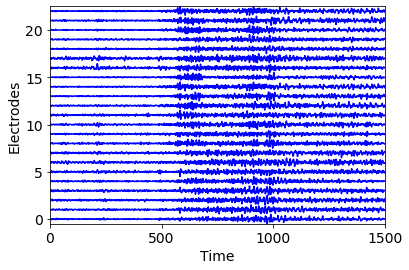

In [3]:
dm = pd.DataFrame()
dm['ad'] = [i for i in range(23)]
predata1 = predata.add(dm['ad'], axis='columns')

from matplotlib.pyplot import MultipleLocator
xxx = predata1.values
times = range(len(xxx))
plt.plot(times,xxx[:,:],'b')

plt.tick_params(axis='both',which='major',labelsize=14)
plt.xlabel('Time',fontsize=14)
plt.ylabel('Electrodes',fontsize=14)
x_major_locator=MultipleLocator(500)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

plt.ylim((-0.5, 22.5))
plt.xlim((0, 1500))

#plt.savefig('image/dataset.jpg',bbox_inches='tight',pad_inches=0.0)
plt.show()

#  Directed Anisotropic Diffusion Map

In [4]:
from numpy import linalg as LA
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os, math
import cv2

In [5]:
#  grad f
def Deriv(y):                     
    diff_x = 1/16                      
    diff_y = []                       
    for i, j in zip(y[0::], y[1::]):
        diff_y.append(j - i)  
        
    slopes = []                       
    for i in range(len(diff_y)):
        slopes.append(diff_y[i] / diff_x)
        
    deriv = []                        
    for i, j in zip(slopes[0::], slopes[1::]):        
        deriv.append((0.5 * (i + j))) 
    deriv.insert(0, slopes[0])        
    deriv.append(slopes[-1])                       
 
    return deriv


prepdata = predata.values
DerivMatx = []    #list 
for i in range(23):
    deriv = Deriv(prepdata[:,i].tolist())
    DerivMatx.append(deriv)

#(23,1500)
DMatx = abs(np.array(DerivMatx)) 


def getData(path):
    filelist = os.listdir( path )
    imglist = []
    for filename in filelist:
        img = np.load(path+filename)
        imglist.append(img) #  (23)

    data=[]
    for img in imglist:
        vector = img.flatten() #(23)
        data.append(vector)
    return data

In [6]:
# directed kernel
def DDM(data, k, Exp, DMatx, t, epsi, **kwargs):
    try:
        kwargs['dim']
    except:
        kwargs['delta']
        trynum = 1
    else:
        trynum = 1
    finally:
        if trynum == 0:
            raise KeyError('specify either dim or delta as keyword argument!')
    
    dataList=[] # create list whose indices will serve as references for the vectors from now on
    for x in data:
        dataList.append(x)
    X = range(len(dataList))  #1500
    
    # construct Markov matrix
    kermatx = []
    for x in X:  
        kermatx.append([])
        for y in X:
            _x = np.array(dataList[x])
            _y = np.array(dataList[y])
            Deriv_x = DMatx[:,x]
            Deriv_y = DMatx[:,y]
            Norm_1 = -k(_x,_y)/epsi
            Norm_2 = -k(Deriv_x*_x,Deriv_y*_y)/epsi**2 
            ker = Exp(Norm_1+Norm_2)
            kermatx[x].append(ker)
            
    newker = kermatx
    
    v = []
    for x in X:
        vx = 0
        for y in X:
            ker = newker[x][y]
            vx += ker
        v.append(math.sqrt(vx))   
    
            
    a = []
    for x in X:  #index 0-1499
        a.append([])
        for y in X:
            ker = newker[x][y]
            a[x].append(ker/(v[x]*v[y]))
    
    trans_p = []
    for x in X:  #index 0-1499
        trans_p.append([])
        for y in X:
            ker = newker[x][y]
            trans_p[x].append(ker/(v[x]**2))
    
    # compute eigenvectors of (a_ij)
    phi = []
    eigval, eigvec = LA.eigh(np.array(a))
    for i in range(len(eigvec)):
        phi.append(eigvec[:, i])
    # reverse order
    eigval[:] = eigval[::-1]
    phi[:] = phi[::-1]
    
    # compute dimension 
    try:
        kwargs['dim']
    except:
        kwargs['delta']
        i=1
        while eigval[i]**t>kwargs['delta']*eigval[1]**t:
            i+=1
        embeddim = i
    else:
        embeddim = kwargs['dim']
    
    
    # compute embedding coordinates
    Psi = []
    for x in X:
        Psi.append([])
        for j in range(embeddim):
            i=j +1 
            Psi[x].append((eigval[i]**t)*phi[i][x]/v[x])
    return (Psi, dataList, eigval, newker,trans_p)

In [7]:
#data folder
if not os.path.exists('data/edata_hb01_03'):
    os.mkdir('data/edata_hb01_03')

for i in range(1500):  
    xxx = prepdata[i,:]
    j = "%05d" % (i+1)
    np.save('data/edata_hb01_03/'+str(j),xxx)

In [8]:
datalist = getData("data/edata_hb01_03/")
my_t = 1
kernelepsi = 1

#directed adm
coordinates, dataList,eigval, pmat,pmat_p = DDM(datalist, 
                                         lambda x,y: LA.norm(x-y), 
                                         lambda x: math.exp(x), 
                                         DMatx, my_t, kernelepsi, dim=2)


In [9]:
a = np.asarray(coordinates)#dim=1
x = a[:,0]
y = a[:,1]

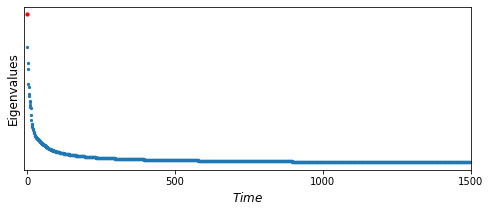

In [10]:
ts = range(len(eigval)-1)
plt.figure(figsize=(8,3))
plt.scatter(ts,eigval[1:],s=5)
plt.scatter(ts[1],eigval[1],s=10,color='r')
plt.xlabel('$Time$',fontsize=12)
plt.ylabel('Eigenvalues',fontsize=12)
x_major_locator=MultipleLocator(500)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim((-10,1500))
plt.yticks([])
#plt.savefig('image/eigenval.jpg',bbox_inches='tight')#,pad_inches=0.0)
plt.show()

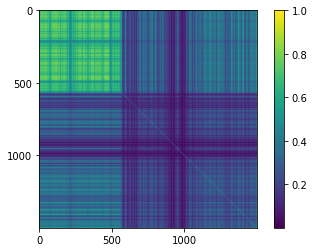

In [11]:
#kernel matrix
pshow = np.array(pmat)
plt.figure() 
plt.imshow(pshow)
plt.colorbar()

x_major_locator=MultipleLocator(500)
y_major_locator=MultipleLocator(500)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
#plt.savefig('image/ker_ddm.jpg',bbox_inches='tight',pad_inches=0.0)
plt.show()

In [12]:
a1 = 2/(x.max()-x.min())
b1 = 1-a1*x.max()
f1 = lambda x: a1*x+b1

a2 = 2/(y.max()-y.min())
b2 = 1-a2*y.max()
f2 = lambda x: a2*x+b2

phi1,phi2 = f1(x),f2(y)

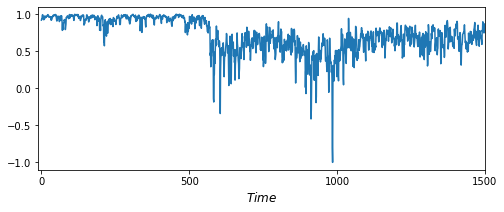

In [13]:
#epsi = 1
#plt.plot(phi1)
ts = range(len(eigval))
plt.figure(figsize=(8,3))
plt.plot(phi1)
plt.xlabel('$Time$',fontsize=12)
#plt.ylabel('Eigenvalues',fontsize=12)
x_major_locator=MultipleLocator(500)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim((-10,1500))
#plt.yticks([])
plt.savefig('image/cor_ddm.jpg',bbox_inches='tight')
plt.show()

# Latent Stochastic dynamics

In [14]:
#恢复默认
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
a1 = 2/(x.max()-x.min())
b1 = 1-a1*x.max()
f1 = lambda x: a1*x+b1

a2 = 2/(y.max()-y.min())
b2 = 1-a2*y.max()
f2 = lambda x: a2*x+b2

cdata = np.concatenate((f1(x).reshape(-1,1),f2(y).reshape(-1,1)),axis=1)

In [16]:
import torch 
import torch.nn as nn
# import torch.nn.init as init
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.utils.data as data

import sys
import numpy as np
from scipy.stats import levy_stable
import datetime

#tfd = tfp.distributions

%load_ext autoreload
%autoreload 2

In [17]:
# notebook parameters
random_seed = 1
step_size = 1/16   # step size

n_hidden_dim = 25

n_input_dim = 4
n_output_dim = 1 

VALIDATION_SPLIT = .1
BATCH_SIZE = 1200


def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    # random.seed(seed)
    

In [18]:
import random
rng = np.random.default_rng(random_seed)
x = cdata[:,0]  
xt0 = x[:-1].tolist()
xt1 = x[1:].tolist()
random.seed(100)
random.shuffle(xt0)
random.seed(100)
random.shuffle(xt1)
xt0,xt1 = np.array(xt0),np.array(xt1)
x_data, y_data = np.expand_dims(xt0[:1200], axis=1), np.expand_dims(xt1[:1200], axis=1)

step_sizes = np.zeros((x_data.shape[0],)) + step_size
xt0

array([0.99443228, 0.8235095 , 0.68155106, ..., 0.46970566, 0.46412765,
       0.87773929])

In [19]:
class Drift1(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.predict = nn.Linear(in_dim, out_dim,bias = False)
        self.inite_weight()
    def inite_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data=torch.Tensor(np.array([0,1,0,-1]))
    def forward(self,input):
        out = self.predict(input)
        return out

class Diff1(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.predict = nn.Linear(in_dim, out_dim,bias = False)
        self.small_init=1e-2
        self.inite_weight()
        
    def inite_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight.data,-self.small_init,self.small_init)
    def forward(self,input):
        out = self.predict(input)
        out = torch.nn.functional.softplus(out) + torch.tensor([1e-13])
        return out
    
    
    
def sindy(x):
    bas0 = torch.ones(x.shape)
    bas2 = x**2
    bas3 = x**3
    y = torch.cat([bas0,x,bas2,bas3], dim=-1)
    return y
def sindy2(x):
    bas0 = torch.ones(x.shape)
    y = torch.cat([bas0,x], dim=-1)
    return y
def sindyc(x):
    bas0 = torch.ones(x.shape)
    y = bas0
    return y

In [20]:
mean_model = Drift1(n_input_dim, n_output_dim)
std_model = Diff1(1, n_output_dim)

small_init = 1e-2
# model = ResNet(dim_ip, hidden_dim, dim_op
optimizer1 = optim.AdamW(mean_model.parameters(), lr=0.005)
optimizer2 = optim.AdamW(std_model.parameters(),lr=0.005)
#optimizer1 = optim.Adamax(mean_model.parameters(), lr=0.001,eps=1e-07)
#optimizer2 = optim.Adamax(std_model.parameters(),lr=0.001, eps=1e-07)
mean_model,std_model

(Drift1(
   (predict): Linear(in_features=4, out_features=1, bias=False)
 ),
 Diff1(
   (predict): Linear(in_features=1, out_features=1, bias=False)
 ))

In [21]:
#def log_prob_loss(mean, std):
tis1 = time.perf_counter()    
epoch = 100

def log_prob_loss(mean, std, step_size, x, y):
    x, y = x.numpy(), y.numpy()
    y_log_prob = torch.ones_like(mean)
    for i in range(x.size):
        #m = nn.Softplus()
        #std1 = std[i]        
        y_dist = torch.distributions.MultivariateNormal(loc = (mean[i]*step_size+torch.Tensor(x[i])),
                                                        covariance_matrix = torch.eye(x[i].size)*std[i]*torch.sqrt(torch.Tensor([step_size])))#torch.sqrt(torch.from_numpy(np.array([step_size]))))
        #print(y_dist.covariance_matrix.shape,y_dist.loc.shape)
        y_dist_prob = -y_dist.log_prob(torch.tensor(y[i]))
        y_log_prob[i] =  y_dist_prob
    return y_log_prob

Loss = np.array([])

x_data1, y_data1 = torch.from_numpy(x_data).float(), torch.from_numpy(y_data).float()
train_dataset = data.TensorDataset(x_data1, y_data1)

loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
    )

for i in range(epoch):    # 对整套数据训练iterations次
    for step, (batch_x, batch_y) in enumerate(loader):
        
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        batch = sindy(batch_x)
        approx_mean = mean_model((batch))
        approx_std = std_model((sindyc(batch_x)))
        log_prob = log_prob_loss(approx_mean, approx_std, step_size, batch_x, batch_y)
        loss = torch.mean(log_prob)
        loss.backward()
        optimizer1.step()
        optimizer2.step()
        Loss = np.append(Loss, loss.detach().numpy())
    print("epoch:",i+1, "Loss:", loss)
    

tis2 = time.perf_counter()
print("Time used:", tis2-tis1)

epoch: 1 Loss: tensor(0.0841, grad_fn=<MeanBackward0>)
epoch: 2 Loss: tensor(0.0823, grad_fn=<MeanBackward0>)
epoch: 3 Loss: tensor(0.0805, grad_fn=<MeanBackward0>)
epoch: 4 Loss: tensor(0.0788, grad_fn=<MeanBackward0>)
epoch: 5 Loss: tensor(0.0770, grad_fn=<MeanBackward0>)
epoch: 6 Loss: tensor(0.0753, grad_fn=<MeanBackward0>)
epoch: 7 Loss: tensor(0.0735, grad_fn=<MeanBackward0>)
epoch: 8 Loss: tensor(0.0718, grad_fn=<MeanBackward0>)
epoch: 9 Loss: tensor(0.0700, grad_fn=<MeanBackward0>)
epoch: 10 Loss: tensor(0.0683, grad_fn=<MeanBackward0>)
epoch: 11 Loss: tensor(0.0666, grad_fn=<MeanBackward0>)
epoch: 12 Loss: tensor(0.0648, grad_fn=<MeanBackward0>)
epoch: 13 Loss: tensor(0.0631, grad_fn=<MeanBackward0>)
epoch: 14 Loss: tensor(0.0614, grad_fn=<MeanBackward0>)
epoch: 15 Loss: tensor(0.0596, grad_fn=<MeanBackward0>)
epoch: 16 Loss: tensor(0.0579, grad_fn=<MeanBackward0>)
epoch: 17 Loss: tensor(0.0562, grad_fn=<MeanBackward0>)
epoch: 18 Loss: tensor(0.0545, grad_fn=<MeanBackward0>)
e

In [23]:
weidd = torch.zeros([2,4])
for param_tensor in mean_model.state_dict():
    #print(param_tensor, "\t", mean_model.state_dict()[param_tensor])
    weidd[0,:] = mean_model.state_dict()[param_tensor]
for param_tensor in std_model.state_dict():
    weidd[1,:1] = std_model.state_dict()[param_tensor]
xweidd1 = weidd.numpy()

In [25]:
xtest = np.expand_dims(xt0[1200:], axis=1)
x_test1 = torch.from_numpy(xtest).float()
estimated_mean = mean_model(sindy(x_test1))
estimated_std = std_model(sindyc(x_test1))
mux = estimated_mean.squeeze().detach().numpy()
sigx = estimated_std.squeeze().detach().numpy()
initx = x_test1.squeeze().detach().numpy()
x_pre1 = mux*step_size+sigx*np.random.rand(1)*step_size**0.5+initx

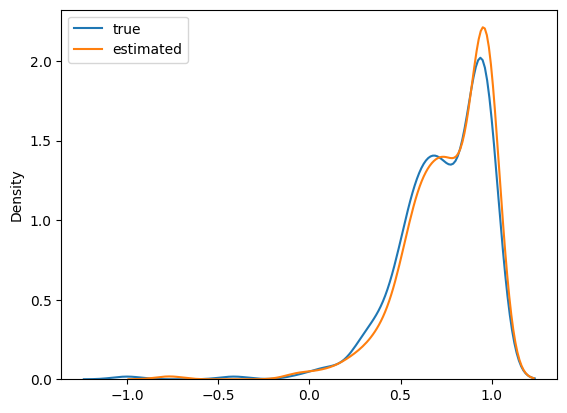

In [26]:
sns.kdeplot(xt1[1200:],label='true')
sns.kdeplot(x_pre1,label='estimated')
plt.legend()
plt.savefig('image/vald1.jpg',bbox_inches='tight')
plt.show()

# Early Warning Indicators

In [27]:
#OM indicator

def Deriv(y):                     
    diff_x = 1/16                      
    diff_y = []                       
    for i, j in zip(y[0::], y[1::]):
        diff_y.append(j - i)  
        
    slopes = []                       
    for i in range(len(diff_y)):
        slopes.append(diff_y[i] / diff_x)
        
    deriv = []                        
    for i, j in zip(slopes[0::], slopes[1::]):        
        deriv.append((0.5 * (i + j))) 
    deriv.insert(0, slopes[0])        
    deriv.append(slopes[-1])                        
 
    return deriv


def Intgl(y):                     
    int_x = 1/16                      
    sum_y = []                       
    for i, j in zip(y[0::], y[1::]):
        sum_y.append((j + i)/2*int_x)  
    
    intgl = np.array(sum_y).sum() 
    return intgl

def gradu(x,para):
    gradu = 0
    for i in range(len(para)):
        ui = x**i*para[i]
        gradu += ui
    return gradu

def ggradu(x,para):
    ggradu = 0
    for i in range(1,len(para)):
        ui = x**(i-1)*para[i]*i
        ggradu += ui
    return ggradu

def OM(x,para,pa_c):
    grad_x = Deriv(x)
    grad_u = gradu(x,para)
    ggrad_u = ggradu(x,para)
    g_x = (abs(grad_x-grad_u)**2)/pa_c**2+ggrad_u
    om_in = Intgl(g_x)
    return om_in

def sliding_window(train, sw_width=50, n_out=0, in_start=0):
    data = train
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        if out_end < len(data):
            train_seq = data[in_start:in_end].reshape(-1)
            X.append(train_seq)
        in_start += 1
        
    return np.array(X)#, np.array(y)

def omindicator(orbitdata,weidd):
    om = []
    para,pa_c = weidd[0],weidd[1,0]
    for i in range(len(orbitdata)):
        omi = OM(orbitdata[i],para,pa_c)
        om.append(omi)
    om = np.array(om)/2
    
    return om

In [28]:
###sample entropy

def time_win(dataset, sw_width=10, in_start=0, q=1):
    data = dataset
    X = []
    for _ in range(len(data)):
        in_end = in_start + sw_width
        if in_end < len(data):
            dataseq = data[in_start:in_end]
            X.append(dataseq)
        in_start += q
        
    return X

def ThetaSet(windata, sw_width=10, start=0, q=1, num_n=20):
    data = windata
    size = data.size
    lend = len(data)
    data = data.reshape(lend,-1)
    dim = size/lend
    XX = []
    
    for i in range(int(dim)):
        in_start = start
        X=[]
        for _ in range(len(data)):
            in_end = in_start + sw_width
            if in_end < len(data)+1:
                if len(X)<num_n:
                    dataseq = data[in_start:in_end,i]
                    X.append(dataseq)
                else: break
            in_start += q
        XX.append(X)
        
    return (XX)

def NumPairs(dataset,k,con_ga): #count A,B
    dataList=[]
    npdataset = np.array(dataset)
    smallwin = npdataset.shape[-1]
    dataset = npdataset.reshape(-1,smallwin).tolist()
    for x in (dataset):
        dataList.append(x)
        
    X = (len(dataList))
    
    count =[]
    dislist = []
    for x in range(X-1):
        for y in range(x+1,X):
            _x = np.array(dataList[x])
            _y = np.array(dataList[y])
            dis = k(_x,_y)
            dislist.append(dis)
            if dis<con_ga:
                count.append(1)
            else:
                count.append(0)
    return np.array(count).sum(),dislist


#sample entropy
def MSampEn(alldata,len_l,m,p,q,con_ga,num_n=20):
    allwin = time_win(alldata, len_l, in_start=0, q=1)
    SEn = []
    if num_n<int((len_l-m-p)/q+1)+1:
        num_n = num_n
    else:
        num_n = int((len_l-m-p)/q+1)
    for winl in allwin:
        Theta_mp = ThetaSet(winl,m+p,0,q,num_n)
        Theta_m = ThetaSet(winl,m,0,q,num_n)
        sig_sd = np.array(winl).std(0).max()
        if np.array(Theta_mp).reshape(-1,m+p).shape[0] == np.array(Theta_m).reshape(-1,m).shape[0]:
            A,_ = NumPairs(Theta_mp,lambda x,y: LA.norm(x-y,ord=np.inf),con_ga)
            B,_ = NumPairs(Theta_m,lambda x,y: LA.norm(x-y,ord=np.inf),con_ga)
            if B==0:
                raise Error('NumPairs(Theta_m)=0, con_ga is too small!')
            elif A==0:
                SEn.append(10)
            else:
                SEn.append(-math.log(A/B))
        else:
            raise Error('len(Theta_mp) != len(Theta_m)')
    return SEn

In [29]:
#OM
input_om = sliding_window(phi1,100)
omind = omindicator(input_om,xweidd1)

#SE
p,m,q = 1, 10, 4
con_ga =0.5
Sys = MSampEn(phi1,100,m,p,q,con_ga)

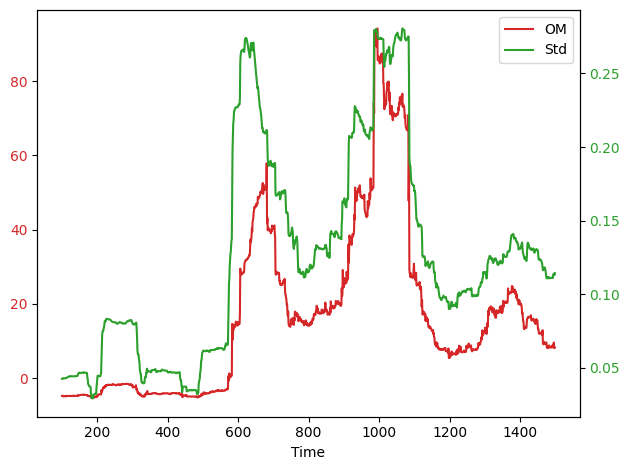

In [30]:
fig, ax1 = plt.subplots()
len_sam = len(input_om)
time = np.arange(100, len_sam+100)
color = 'tab:red'
ax1.set_xlabel('Time')
#ax1.set_ylabel('OM', color=color)
l1, = ax1.plot(time,omind, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
#ax2.set_ylabel('Std', color=color)  # we already handled the x-label with ax1
l2, = ax2.plot(time,input_om.std(-1), color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.legend(handles=[l1, l2], labels=['OM', 'Std'], loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('image/OM.jpg',bbox_inches='tight')
plt.show()

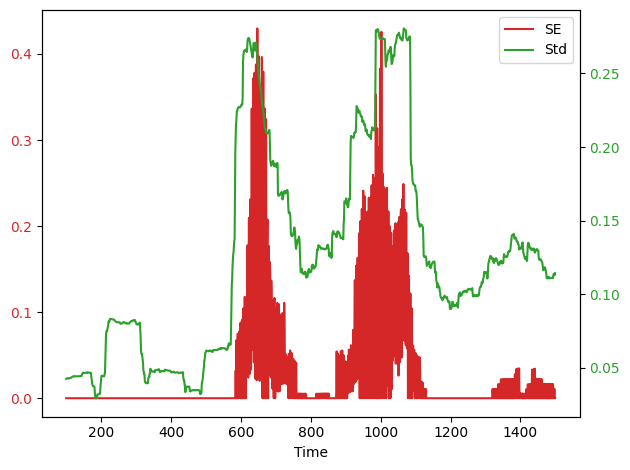

In [31]:
fig, ax1 = plt.subplots()
len_sam = len(input_om)
time = np.arange(100, len_sam+100)
color = 'tab:red'
ax1.set_xlabel('Time')

l1, = ax1.plot(time,Sys, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'

l2, = ax2.plot(time,input_om.std(-1), color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.legend(handles=[l1, l2], labels=['SE', 'Std'], loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('image/SE.jpg',bbox_inches='tight')
plt.show()

In [32]:
def sliding_window(train, sw_width=50, n_out=0, in_start=0):
    data = train
    X = []
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        if out_end < len(data):
            train_seq = data[in_start:in_end].reshape(-1)
            X.append(train_seq)
        in_start += 1
        
    return np.array(X)
 
def transitonprob(orbitdata,time,splitpoint):
    cab_ca = []
    for i in range(time):
        ia = len(orbitdata[:,0][np.where(orbitdata[:,0]>=splitpoint)])
        ib = orbitdata[:,i][np.where(orbitdata[:,0]>=splitpoint)]
        iab = len(ib[np.where(ib>splitpoint)])
        cab_ca.append(1-iab/ia)
    cab_ca = np.array(cab_ca)
    
    return cab_ca

In [33]:
#TP
qx1 = sliding_window(phi1,100)
len_sam1 = len(qx1)
indidata1 = qx1.transpose()
splitpoint1 = 0.8
Cabca1 = transitonprob(indidata1,len_sam1,splitpoint1)
prob = np.zeros(len_sam1)+0.5

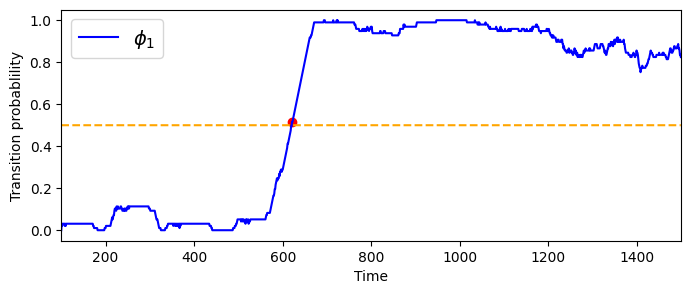

521

In [34]:
plt.figure(figsize=(8,3))
plt.plot(np.arange(100, len_sam1+100),Cabca1,c='b',label=r'$\phi_1$')

plt.plot(np.arange(100, len_sam1+100),prob,linestyle='--',c='orange')
plt.scatter(np.arange(100, len_sam1+100)[(np.where(Cabca1>0.5)[0]).min()],Cabca1[(np.where(Cabca1>0.5)[0]).min()],color='r')
plt.xlabel('Time')
plt.legend(fontsize=14)
plt.xlim(100, len_sam1+100)
plt.ylabel('Transition probablility')
plt.savefig('image/trantwo.jpg',bbox_inches='tight')
plt.show()
(np.where(Cabca1>0.5)[0]).min()